In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from urllib.request import urlopen
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import requests
from bs4 import BeautifulSoup as soup
from matplotlib import pyplot as plt

In [2]:
# importing datasets (4 Amazon review datasets)

appliance_df = pd.read_csv('amazon_reviews_us_Major_Appliances_v1_00.tsv', sep='\t', error_bad_lines=False)
apparel_df = pd.read_csv('amazon_reviews_us_Apparel_v1_00.tsv', sep='\t', error_bad_lines=False)
sports_df = pd.read_csv('amazon_reviews_us_Sports_v1_00.tsv', sep='\t', error_bad_lines=False,
                       dtype={'helpful_votes': 'float64',
                             'star_rating': 'object',
                             'total_votes': 'float64'})
electronics_df = pd.read_csv('amazon_reviews_us_Electronics_v1_00.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 5583: expected 15 fields, saw 22\nSkipping line 22814: expected 15 fields, saw 22\nSkipping line 22883: expected 15 fields, saw 22\nSkipping line 29872: expected 15 fields, saw 22\nSkipping line 37242: expected 15 fields, saw 22\nSkipping line 59693: expected 15 fields, saw 22\n'
b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fiel

b'Skipping line 945450: expected 15 fields, saw 22\nSkipping line 949785: expected 15 fields, saw 22\nSkipping line 958534: expected 15 fields, saw 22\n'
b'Skipping line 1006147: expected 15 fields, saw 22\nSkipping line 1020875: expected 15 fields, saw 22\nSkipping line 1027474: expected 15 fields, saw 22\nSkipping line 1033688: expected 15 fields, saw 22\n'
b'Skipping line 1056719: expected 15 fields, saw 22\nSkipping line 1067438: expected 15 fields, saw 22\nSkipping line 1079099: expected 15 fields, saw 22\nSkipping line 1085814: expected 15 fields, saw 22\nSkipping line 1112836: expected 15 fields, saw 22\n'
b'Skipping line 1124957: expected 15 fields, saw 22\nSkipping line 1138765: expected 15 fields, saw 22\nSkipping line 1148270: expected 15 fields, saw 22\nSkipping line 1160930: expected 15 fields, saw 22\nSkipping line 1162655: expected 15 fields, saw 22\n'
b'Skipping line 1192443: expected 15 fields, saw 22\nSkipping line 1229660: expected 15 fields, saw 22\nSkipping line 12

b'Skipping line 714935: expected 15 fields, saw 22\n'
b'Skipping line 749608: expected 15 fields, saw 22\nSkipping line 753868: expected 15 fields, saw 22\nSkipping line 762504: expected 15 fields, saw 22\nSkipping line 771706: expected 15 fields, saw 22\nSkipping line 773376: expected 15 fields, saw 22\n'
b'Skipping line 792407: expected 15 fields, saw 22\nSkipping line 793933: expected 15 fields, saw 22\nSkipping line 813269: expected 15 fields, saw 22\nSkipping line 835491: expected 15 fields, saw 22\nSkipping line 841176: expected 15 fields, saw 22\nSkipping line 844604: expected 15 fields, saw 22\n'
b'Skipping line 857952: expected 15 fields, saw 22\nSkipping line 859568: expected 15 fields, saw 22\nSkipping line 860789: expected 15 fields, saw 22\nSkipping line 863093: expected 15 fields, saw 22\nSkipping line 881608: expected 15 fields, saw 22\nSkipping line 891157: expected 15 fields, saw 22\nSkipping line 893799: expected 15 fields, saw 22\nSkipping line 906438: expected 15 fi

In [3]:
# data processing
appliance_df = appliance_df[['star_rating', 'review_body']]
appliance_df = appliance_df.dropna()
apparel_df = apparel_df[['star_rating', 'review_body']]
apparel_df = apparel_df.dropna()
sports_df = sports_df[['star_rating', 'review_body']]
sports_df = sports_df.dropna()
electronics_df = electronics_df[['star_rating', 'review_body']]
electronics_df = electronics_df.dropna()

appliance_df = appliance_df.astype({'star_rating': 'int32', 'review_body': 'str'})
apparel_df = apparel_df.astype({'star_rating': 'int32', 'review_body': 'str'})
sports_df = sports_df.astype({'star_rating': 'int32', 'review_body': 'str'})
electronics_df = electronics_df.astype({'star_rating': 'int32', 'review_body': 'str'})

# 4 or 5 star ratings are positive
pos_appliance_df = appliance_df[(appliance_df['star_rating'] == 4) | (appliance_df['star_rating'] == 5)][:25000]
pos_apparel_df = apparel_df[(apparel_df['star_rating'] == 4) | (apparel_df['star_rating'] == 5)][:25000]
pos_sports_df = sports_df[(sports_df['star_rating'] == 4) | (sports_df['star_rating'] == 5)][:25000]
pos_electronics_df = electronics_df[(electronics_df['star_rating'] == 4) | (electronics_df['star_rating'] == 5)][:25000]

# 1 and 2 star ratings are negative
neg_appliance_df = appliance_df[(appliance_df['star_rating'] == 1) | (appliance_df['star_rating'] == 2)][:25000]
neg_apparel_df = apparel_df[(apparel_df['star_rating'] == 1) | (apparel_df['star_rating'] == 2)][:25000]
neg_sports_df = sports_df[(sports_df['star_rating'] == 1) | (sports_df['star_rating'] == 2)][:25000]
neg_electronics_df = electronics_df[(electronics_df['star_rating'] == 1) | (electronics_df['star_rating'] == 2)][:25000]

# combining into one df (need to grab 50)

In [4]:
# combining data frame
combined_df = pd.concat([pos_appliance_df, pos_apparel_df, pos_sports_df, pos_electronics_df,
                        neg_appliance_df, neg_apparel_df, neg_sports_df, neg_electronics_df], axis=0)

In [5]:
combined_df.shape #100k positive and 100k negative

(200000, 2)

In [6]:
# creating sentiment column
def applySentiment(rating):
    if rating == 4 or rating == 5:
        return 1
    elif rating == 1 or rating == 2:
        return 0
    
combined_df['sentiment'] = combined_df['star_rating'].apply(lambda x: applySentiment(x))

In [35]:
# cleaning
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([lemmatizer.lemmatize(word) for word in tokens])
    return text

# use for tfidf (tokens are separated in a list)
def clean_text2(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lemmatizer.lemmatize(word) for word in tokens]
    return text

combined_df['cleaned_reviews'] = combined_df['review_body'].apply(lambda x: clean_text(x))
combined_df.head()

,star_rating,review_body,sentiment,cleaned_reviews
0,5,What a great stove. What a wonderful replacem...,1,what a great stove what a wonderful replacemen...
1,5,worked great,1,worked great
2,5,Part exactly what I needed. Saved by purchasi...,1,part exactly what i needed saved by purchasing...
3,5,Love my refrigerator! ! Keeps everything cold...,1,love my refrigerator keep everything coldwill ...
4,5,No more running to the store for ice! Works p...,1,no more running to the store for ice work perf...


In [8]:
# download
combined_df.to_csv('reviews.csv')

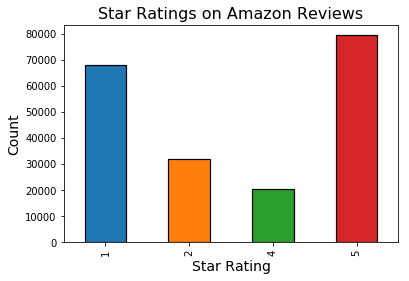

In [9]:
# EDA / VIZ

# Star Rating Distribution
star_rating_dist = pd.value_counts(combined_df['star_rating'].values, sort=False)
# combined_df['star_rating'].hist(bins=5, color='royalblue', edgecolor='black', linewidth=1.4)
# plt.xticks(np.arange(1,6,1))
star_rating_dist.plot.bar(edgecolor='black', linewidth=1.2)
plt.title('Star Ratings on Amazon Reviews', size=16)
plt.xlabel('Star Rating', size=14)
plt.ylabel('Count', size=14)
plt.show()

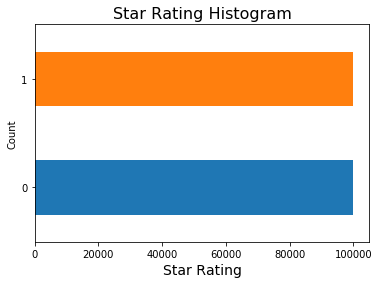

In [10]:
# Sentiment Distribution
sentiment_dist = pd.value_counts(combined_df['sentiment'].values, sort=False)
sentiment_dist.plot.barh()
plt.title('Star Rating Histogram', size=16)
plt.xlabel('Star Rating', size=14)
plt.ylabel('Count')
plt.show()

In [92]:
# # picture of vectorizer (will use sample)
# dontwant = ["", 110, 220, "3rd", 4000]
# review_sample = combined_df.iloc[:20]
# vectorizer = TfidfVectorizer(analyzer=clean_text2)
# y = review_sample['sentiment']
# X = vectorizer.fit_transform(review_sample['review_body'])
# tf_idf_df = pd.DataFrame(X.toarray())
# tf_idf_df.columns = vectorizer.get_feature_names()
# tf_idf_df[tf_idf_df.columns.all(dontwant)]
# tf_idf_df

In [36]:
# bigrams
vectorizer = CountVectorizer(ngram_range=(1,2))

In [12]:
# TFIDF Vectorizer
# vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopwords)
# vectorizer = TfidfVectorizer(analyzer=clean_text2)

In [37]:
# dependent variable (0 or 1 for bad or good review)
y = combined_df['sentiment']

In [38]:
# convert reviews to features
X = vectorizer.fit_transform(combined_df['cleaned_reviews'])

In [39]:
print(y.shape)
print(X.shape)
# 767578 with uni + bigrams
# 41208 unigrams
# 726370 bigrams

(200000,)
(200000, 1492583)


In [40]:
import random
# getting features for unigram + bigrams

grams = vectorizer.get_feature_names()
for i in range(10):
    print(random.choice(grams))

skip if
gauranteed and
muso
through fair
the position
diagnosing itbr
enough red
thisplease
adhesive remover
add penalty


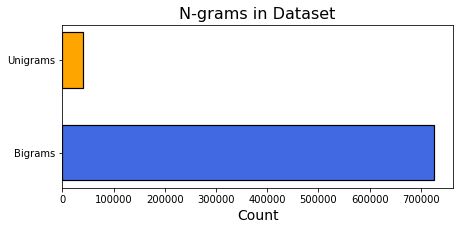

In [41]:
# update later
plt.subplots(figsize=(7,3))
plt.barh(['Bigrams', 'Unigrams'], [726370, 41208], height=0.6, color=['royalblue', 'orange'], edgecolor='black',
        linewidth=1.2)
plt.title('N-grams in Dataset', size=16)
plt.xlabel('Count', size=14)
plt.show()

In [42]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
C_list = [0.01, 0.05, 0.25, 0.5, 1]
accuracy_rates = []

for c in C_list:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    accuracy_rates.append(accuracy_score(y_test, lr.predict(X_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.921975
Accuracy for C=0.05: 0.933175
Accuracy for C=0.25: 0.936325
Accuracy for C=0.5: 0.937
Accuracy for C=1: 0.936475


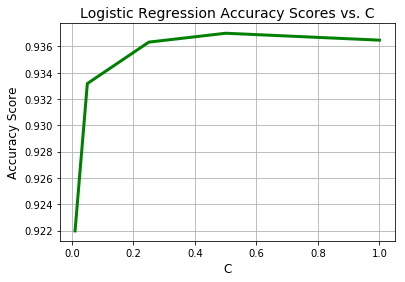

In [44]:
plt.plot(C_list, accuracy_rates, color='green', linewidth=3)
plt.grid(b=True)
plt.title("Logistic Regression Accuracy Scores vs. C", size=14)
plt.xlabel("C", size=12)
plt.ylabel("Accuracy Score", size=12)
plt.show()

In [45]:
# training Naive Bayes Classifier
classifier = LogisticRegression(C=0.5)
# classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
# testing accuracy with test set
roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])

0.9758157282874268

In [47]:
reviews_array = np.array(["the product was okay, probably will not buy again"])
reviews_vector = vectorizer.transform(reviews_array)
print(classifier.predict(reviews_vector))

[0]


In [48]:
# evaluation
feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), classifier.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[10:20]:
    print(best_positive)
    
print()

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print(best_negative)

('wonderful', 2.375482307723073)
('fantastic', 2.370819565735429)
('best', 2.194904474996242)
('just what', 2.1695042283159203)
('beautiful', 2.1500684588565204)
('outstanding', 2.129858584636687)
('no issue', 2.0773002024669345)
('excelent', 2.0766824033935167)
('nice', 2.058212693656944)
('good', 1.9812031055741421)

('not good', -3.3881830331558875)
('no good', -2.946403176441119)
('doesnt work', -2.851414266177792)
('horrible', -2.8293617157391693)
('poor', -2.8129939889250406)
('terrible', -2.787026968027005)
('broke', -2.6827092643018706)
('didnt work', -2.665810781687959)
('junk', -2.66000338990619)
('not great', -2.64807122140594)


In [49]:
# evaluation
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[18722,  1285],
       [ 1235, 18758]])

In [50]:
# model evaluation metrics (precision, recall, F1)
print("precision: {}".format(precision_score(y_test, y_pred)))
print("recall: {}".format(recall_score(y_test, y_pred)))
print("f1 score: {}".format(f1_score(y_test, y_pred)))

precision: 0.9358878411415457
recall: 0.9382283799329766
f1 score: 0.9370566490158857


In [59]:
# NOW FOR SLICKDEALS DATA

sdeals_page = "http://slickdeals.net"
url = urlopen(sdeals_page)
url_read = url.read()
url.close()

page_soup = soup(url_read, "html.parser")

grid_deals = page_soup.find("ul", {"class":"dealTiles gridDeals",
                                "data-role":"deal-tiles"})
item_container = grid_deals.find_all('li')

def fix_text(text):
    text = re.sub(r'&lpar', '(', text)
    text = re.sub(r'&rpar', ')', text)
    text = re.sub(r'&plus', '+', text)
    text = re.sub(r'&apos', '\'', text)
    text = re.sub(r'&colon', ':', text)
    text = re.sub(r'&sol', '/', text)
    text = re.sub(r'&dollar', '$', text)
    text = re.sub(r'&comma', ',', text)
    text = re.sub(r'&period', '.', text)
    text = re.sub(r'&percnt', '%', text)
    text = re.sub(r'&excl', '?', text)
    text = re.sub(r'&num', '#', text)
    return text


df = pd.DataFrame(columns=['Item', 'Price', 'Old Price', 'Url', 'Positive Feedback Rating'])
counter = 0

test_counter = 0

# store content regex
content_re = re.compile(r'\w+')
space_re = re.compile(r'\s{2,}')

for item in item_container:
    try:
        # will add instances to df
        to_add = []
        
        # getting the item's title
        item_title = item.find("a", {"class":"itemTitle"}).text.strip()
        # cleaning the &___; - this may be added onto
        item_title = fix_text(item_title)
        
        # item price
        item_price = item.find('div', {'class':'itemPrice'}).text.strip()[:50].strip()
        
        to_add.append(item_title)
        to_add.append(item_price)
        
        # old item price
        try:
            old_item_price = item.find('div', {'class':'listPrice'}).text
        except:
            old_item_price = ""
            
        to_add.append(old_item_price)
        
       

        
        # link to each product          
        # dictionary of divs, then getting the tail end or url link
        attributes_dictionary_list = item.findAll('div')
        for div in attributes_dictionary_list:
            attributes = div.attrs
            if 'data-href' in attributes.keys():
                url_tail = div['data-href']
                break
        product_page = (sdeals_page + url_tail).strip()
        to_add.append(product_page)
        
        # don't do credit cards (takes too long bc too many comments)
        card_re = re.compile(r'-card-')
        if bool(card_re.search(url_tail.strip())) == False:

            # now want to look at the comments for each product
            # doing this for multiple pages

            # grabbing last page of comments
            page_url = urlopen(product_page)
            page_url_read = page_url.read()
            page_url.close()  
            product_page_soup = soup(page_url_read, 'html.parser')
            last_page = int(product_page_soup.find('div', {'id':'commentsBottomRow'}).find('span', {'id':'totalPageNum'}).text)


            # removing 'src=frontpage' and 'src=sticky-24'
            product_page = re.sub(r'src=frontpage', "", product_page)
            product_page = re.sub(r'src=sticky-24', "", product_page)
            print(product_page)

            # list to add all comments
            total_comment_list = []
            
            # using to iterate through comments pages
            page_counter = 1

            while page_counter <= last_page:
                comments_page = product_page + "page=" + str(page_counter)
                page_url = urlopen(comments_page)
                page_url_read = page_url.read()
                page_url.close()  
                product_page_soup = soup(page_url_read, 'html.parser')

                comments_soup = product_page_soup.find('div', {'id':'posts'})
                content_soup = comments_soup.findAll('div', {'class':'postTextContent'})

                product_content = [comment.findAll(text=True, recursive=False) for comment in content_soup]
                product_comments = [comment for comment in product_content if comment]

                # cleaning

                for comment_list in product_comments:
                    comment = []
                    for instance in comment_list:
                        comment.extend(instance)
                    comment_joined = "".join(comment)
                    comment = re.sub(r'\n', ' ', comment_joined)
                    comment = re.sub(r'\r', ' ', comment)
                    comment = re.sub(r' +', ' ', comment)

                    total_comment_list.append(comment[1:-1])

                page_counter += 1

    #         print(total_comment_list)

            # after getting slickdeals items into the dataframe, now apply the machine learning model to predict
            # percent positive feedback for each product
            positive = 0
            negative = 0
            for comment in total_comment_list:
                # cleaning
                comment = fix_text(comment)
                comment = clean_text(comment)
                print(comment, end=" ")
                # inputting each comment and predicting the outcome (0 or 1 sentiment)
                reviews_array = np.array([comment])
                reviews_vector = vectorizer.transform(reviews_array)
                print(classifier.predict(reviews_vector)[0])
                if classifier.predict(reviews_vector)[0] == 0: # if negative sentiment, increment negative
                    negative += 1
                elif classifier.predict(reviews_vector)[0] == 1:
                    positive += 1

            # percent of commments that have positive sentiment for the product
            total_score = positive / (positive + negative)
            to_add.append(total_score)

            # adding to df
            df.loc[counter] = to_add
            # incrementing item counter
            counter += 1

            # temp test code
            test_counter += 1
            if test_counter == 10:
                break
                
        
    # end of front page deals
    except AttributeError:
        print("There is an error")
        break
        

        



http://slickdeals.net/f/13815848-adidas-men-s-argentina-home-soccer-jersey-xs-s-xl-2xl-33-75-free-shipping?
nice deal but no l 1
my wife is from argentina and i lived there for a couple year in for a few thanks op 1
very nice deal for my favorite team jersey in for one 1
too bad no m or l size 0
same 1
they run small fyi i wear large everything xl in these 0
the most beautiful and iconic soccer jersey in existence in for one 1
che boludos 1
messi 10 0
im a diego fan myself 1
http://slickdeals.net/f/13816223-spigen-steadiboost-super-compact-qi-10w-wireless-charger-9-99-fs?
look to be a pretty good deal 1
usb c input cable im in for one 1
fan of their case but fakespot f 1
what doe that f tell you 1
press f in the chat 1
no ac adapter no deal a far a i am concerned 0
fast i think 1
paid review 0
unless you really like the included usbc cable id go with this anker device 1
difference 1
5999 review v 69 1
doe it still charge io device at 75w after 131 1
http://slickdeals.net/f/13815983-xbo

http://slickdeals.net/f/13815611-boston-to-barcelona-spain-191-rt-nonstop-airfares-on-iberia-level-limited-travel-march-and-october-december-2020?
can anyone explain why rocbos is 139 and bosbcn is 191 but the same flight rocbcn is 1250 0
awesome deal 1
the magic of airline pricing 1
always dry for dallasfort worth or crazy expensive 1
flew to barcelona february of 2019 via level worst traveling experience of my life didnt help that when we booked our ticket it wa iberia our confirmation said iberia our online boarding pas said iberia wasnt until we arrived at the airport and saw no iberia that we found out it wa their newly launched budget airline level it wasnt just u either everyone wa looking for iberia to check in would have gladly paid much more to not be on that flight 0
if it on the same airline or a partner alliance you can request they check it all the way through to bcn in this case done it multiple time 0
any babe in barcelona 1
yes level is pretty bad flew oakbcn last year

http://slickdeals.net/f/13815212-gerber-gdc-zip-blade-amazon-8-34-after-coupon?
791 with s 5 discount 5 item or more in your s order 1
it look like they are matching walmarts 862 price with 28 pickup discount i guess doing the coupon stop the undercutting cycle we used to see that would keep dropping the price 1
it the lowest price by 016 before coupon it been within 1 about 8 time in the last year each instance lasting 12 week coupon history unknown 0
a box cutter if you search amazon there a bunch of option for other brand this price is comparable 1
lot of bad review about quality and difficulty opening the knife ill pas 1
yeah they started doing that a while back unfortunately 0
i havent tried this unit but i prefer something difficult to open when im keeping it in my pocket with my key dont want it unintentionally opening and then slicing my finger when i reach in to grab my car key or worse yet poking it blade into my junk 0
i hang my key off by beltloop i hope the disconnecting c

http://slickdeals.net/f/13815887-harry-potter-and-the-goblet-of-fire-illustrated-hardcover-19-19-amazon?
id like to edit the title to add the price and location but cant figure it out anyone know howif i can do that 0
unfortunately at this time it not possible to update the title from the app i updated it for you 0
seems like a good price thanks op 1
nice price too bad we have to wait until 2021 to get the next book 1
perfect timing already picked first three with buy 2 get 1 free offer earlier this week 1
is this still available 1
anyone know why this is categorized in range hood appliance on amazon 1
look like it is still available 1
nice thanks 1
i just picked this up along with the first 3 that are all qualifying for the b2g1 free offer at amazon my total cost wa 6447 for all 4 book this way 0
just looked it up and it appears it is still a valid offer 0
it is showing up a a b3g1 free and no longer a b2g1 deal for me however i wanted to buy all 4 book anyway so the final price ended

In [63]:
# results are posted
df.to_html('Product Results.html')